In [1]:
##############################################################################################################
# DESCRIPTION: 
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

class HyperParams:
    pass
hyperparams = HyperParams()

hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 120
hyperparams.BATCH_SIZE = 32

hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0001_0010"
MODEL_NAME = "0001_0010-64-aeconnect-xe4"

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.1418
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.2947

from tensorflow.keras.optimizers import Nadam
hyperparams.OPTIMIZER = Nadam(learning_rate=0.0001)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelC as train
import ReportsK as reports
import AEConnectionsF as model_factory

In [4]:
##################
# MODEL DEFINITION
##################
model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
______________________________________________________________________________________________

{'name': 'Nadam',
 'learning_rate': 0.0001,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [5]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = \
            dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = \
            dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/
Noisy files:19657
Nitid files:19657
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/validation/
Noisy files:4900
Nitid files:4900


In [6]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)


hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 50 )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/120
615/615 [==============================] - 38s 50ms/step - loss: 0.0643 - val_loss: 0.0476
Epoch 2/120
615/615 [==============================] - 30s 49ms/step - loss: 0.0427 - val_loss: 0.0452
Epoch 3/120
615/615 [==============================] - 30s 49ms/step - loss: 0.0413 - val_loss: 0.0451
Epoch 4/120
615/615 [==============================] - 30s 49ms/step - loss: 0.0397 - val_loss: 0.0470
Epoch 5/120
615/615 [==============================] - 30s 49ms/step - loss: 0.0317 - val_loss: 0.0307
Epoch 6/120
615/615 [==============================] - 30s 49ms/step - loss: 0.0284 - val_loss: 0.0303
Epoch 7/120
615/615 [==============================] - 30s 49ms/step - loss: 0.0270 - val_loss: 0.0255
Epoch 8/120
615/615 [==============================] - 30s 49ms/step - loss: 0.0261 - val_loss: 0.0268
Epoch 9/120
615/

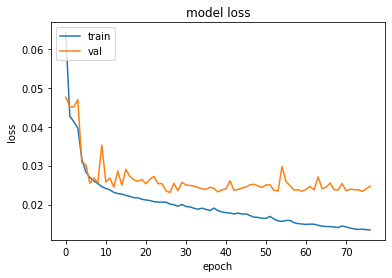

In [7]:
##################
# REPORTS
##################
reports.plotHistory( hist )

In [8]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Black image found
Black image found
Images count =4900
Best RMSENZ  =4616 (0.94)
Best MAENZ   =4618 (0.94)
Best PSNR    =4616 (0.94)
Best Accuracy=4563 (0.93)
RMSE-NZ  Pred=0.0314  Noisy=0.1031
MAE-NZ   Pred=0.0247  Noisy=0.0937
PSNR     Pred=17.7 dB Noisy=8.8 dB
Accuracy Pred=0.36    Noisy=0.12
SSM      Pred=0.80    Noisy=0.41
HOG MSE  Pred=0.08    Noisy=0.08


In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-aeconnect-xe4\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [10]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test/
Noisy files:17
Nitid files:17
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_00_2_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_00_2_nitid_idx008.tif


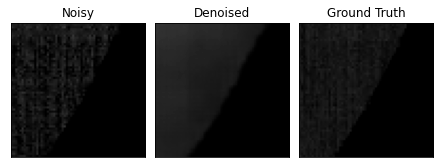

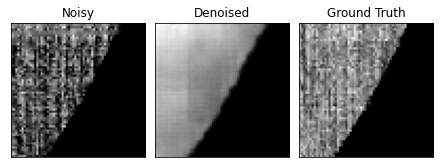

RMSE-NZ  Pred=0.0432  Noisy=0.0423 WORST
MAE-NZ   Pred=0.0276  Noisy=0.0298 BEST
PSNR     Pred=11.0 dB Noisy=11.1 dB WORST
Accuracy Pred=0.48    Noisy=0.36 BEST
SSM      Pred=0.77    Noisy=0.62
HOG MSE  Pred=0.05    Noisy=0.01
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_01_5_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_01_5_nitid_idx017.tif


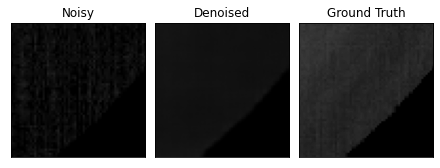

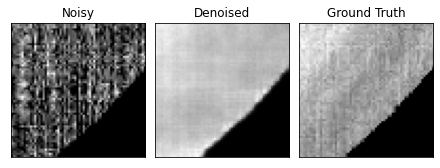

RMSE-NZ  Pred=0.0812  Noisy=0.1180 BEST
MAE-NZ   Pred=0.0701  Noisy=0.1096 BEST
PSNR     Pred=9.3 dB Noisy=6.1 dB BEST
Accuracy Pred=0.20    Noisy=0.07 BEST
SSM      Pred=0.67    Noisy=0.60
HOG MSE  Pred=0.03    Noisy=0.09
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_02_04_9_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_02_04_9_nitid_idx146.tif


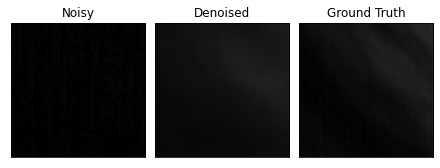

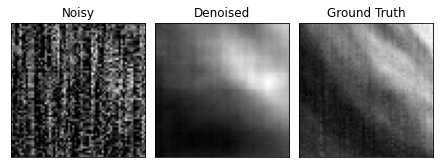

RMSE-NZ  Pred=0.0189  Noisy=0.0587 BEST
MAE-NZ   Pred=0.0155  Noisy=0.0477 BEST
PSNR     Pred=18.5 dB Noisy=8.6 dB BEST
Accuracy Pred=0.37    Noisy=0.13 BEST
SSM      Pred=0.87    Noisy=0.28
HOG MSE  Pred=0.06    Noisy=0.07
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_11_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_11_nitid_idx134.tif


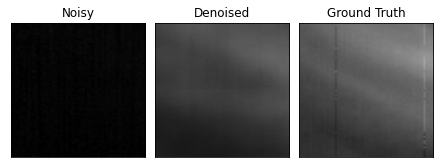

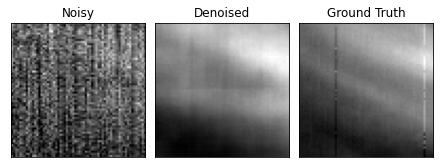

RMSE-NZ  Pred=0.1114  Noisy=0.3357 BEST
MAE-NZ   Pred=0.1059  Noisy=0.3214 BEST
PSNR     Pred=15.2 dB Noisy=5.6 dB BEST
Accuracy Pred=0.00    Noisy=0.00 BEST
SSM      Pred=0.82    Noisy=0.14
HOG MSE  Pred=0.07    Noisy=0.11
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_13_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_13_nitid_idx134.tif


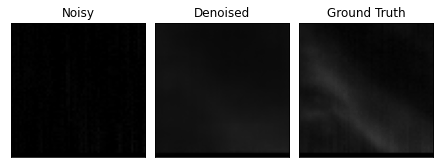

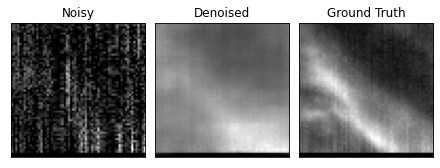

RMSE-NZ  Pred=0.0347  Noisy=0.0869 BEST
MAE-NZ   Pred=0.0253  Noisy=0.0747 BEST
PSNR     Pred=15.7 dB Noisy=7.7 dB BEST
Accuracy Pred=0.26    Noisy=0.01 BEST
SSM      Pred=0.84    Noisy=0.23
HOG MSE  Pred=0.04    Noisy=0.11
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_3_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_3_nitid_idx134.tif


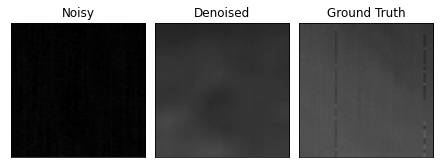

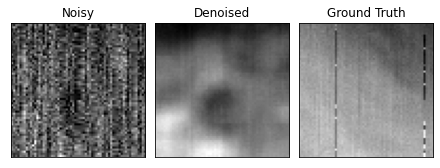

RMSE-NZ  Pred=0.0778  Noisy=0.2662 BEST
MAE-NZ   Pred=0.0741  Noisy=0.2643 BEST
PSNR     Pred=13.8 dB Noisy=3.1 dB BEST
Accuracy Pred=0.00    Noisy=0.00 BEST
SSM      Pred=0.83    Noisy=0.14
HOG MSE  Pred=0.08    Noisy=0.10
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_5_nitid_idx134.tif


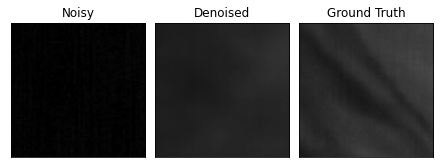

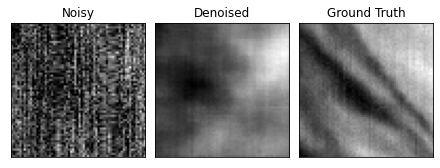

RMSE-NZ  Pred=0.0522  Noisy=0.1729 BEST
MAE-NZ   Pred=0.0460  Noisy=0.1686 BEST
PSNR     Pred=14.8 dB Noisy=4.4 dB BEST
Accuracy Pred=0.09    Noisy=0.00 BEST
SSM      Pred=0.83    Noisy=0.16
HOG MSE  Pred=0.12    Noisy=0.15
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0338_04_00_10_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0338_04_00_10_nitid_idx008.tif


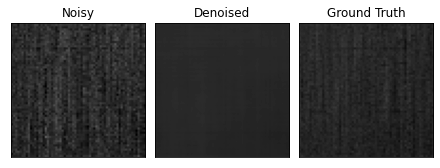

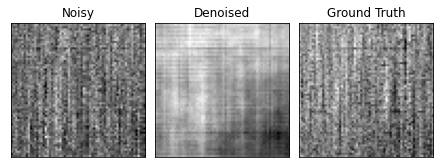

RMSE-NZ  Pred=0.0267  Noisy=0.0606 BEST
MAE-NZ   Pred=0.0211  Noisy=0.0478 BEST
PSNR     Pred=19.2 dB Noisy=12.0 dB BEST
Accuracy Pred=0.30    Noisy=0.15 BEST
SSM      Pred=0.62    Noisy=0.32
HOG MSE  Pred=0.04    Noisy=0.03
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_04_03_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_04_03_5_nitid_idx134.tif


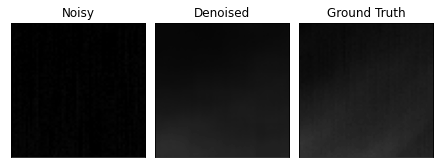

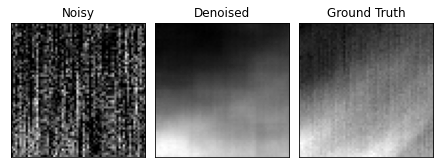

RMSE-NZ  Pred=0.0295  Noisy=0.1061 BEST
MAE-NZ   Pred=0.0269  Noisy=0.0983 BEST
PSNR     Pred=16.9 dB Noisy=5.8 dB BEST
Accuracy Pred=0.09    Noisy=0.00 BEST
SSM      Pred=0.89    Noisy=0.25
HOG MSE  Pred=0.21    Noisy=0.04
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_05_03_8_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_05_03_8_nitid_idx134.tif


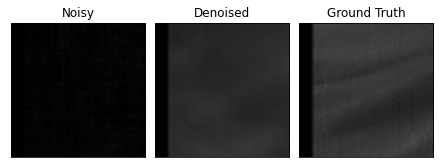

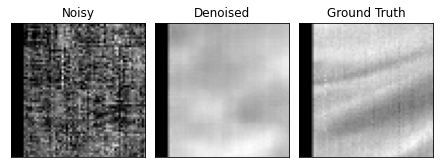

RMSE-NZ  Pred=0.0524  Noisy=0.1969 BEST
MAE-NZ   Pred=0.0418  Noisy=0.1941 BEST
PSNR     Pred=14.7 dB Noisy=3.2 dB BEST
Accuracy Pred=0.20    Noisy=0.00 BEST
SSM      Pred=0.89    Noisy=0.16
HOG MSE  Pred=0.02    Noisy=0.24
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0353_09_00_15_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0353_09_00_15_nitid_idx008.tif


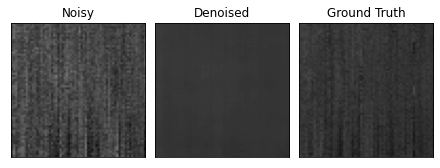

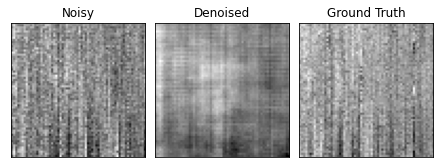

RMSE-NZ  Pred=0.0294  Noisy=0.0925 BEST
MAE-NZ   Pred=0.0226  Noisy=0.0774 BEST
PSNR     Pred=20.1 dB Noisy=10.1 dB BEST
Accuracy Pred=0.29    Noisy=0.06 BEST
SSM      Pred=0.63    Noisy=0.30
HOG MSE  Pred=0.04    Noisy=0.03
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_00_5_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_00_5_nitid_idx008.tif


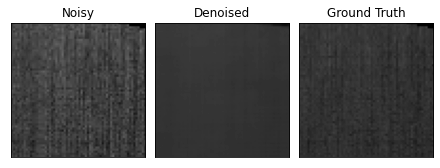

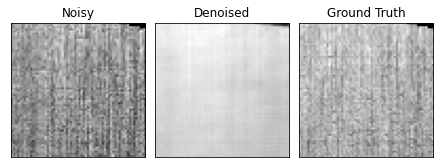

RMSE-NZ  Pred=0.0243  Noisy=0.0770 BEST
MAE-NZ   Pred=0.0186  Noisy=0.0644 BEST
PSNR     Pred=21.3 dB Noisy=11.2 dB BEST
Accuracy Pred=0.35    Noisy=0.08 BEST
SSM      Pred=0.70    Noisy=0.36
HOG MSE  Pred=0.22    Noisy=0.03
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_01_7_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_01_7_nitid_idx017.tif


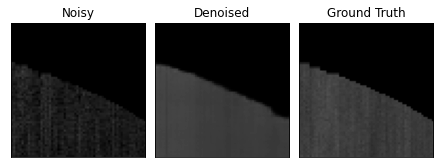

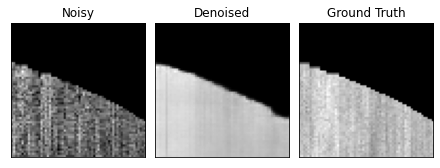

RMSE-NZ  Pred=0.0212  Noisy=0.1235 BEST
MAE-NZ   Pred=0.0104  Noisy=0.1063 BEST
PSNR     Pred=23.5 dB Noisy=8.2 dB BEST
Accuracy Pred=0.67    Noisy=0.19 BEST
SSM      Pred=0.87    Noisy=0.65
HOG MSE  Pred=0.07    Noisy=0.01
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0618_03_01_9_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0618_03_01_9_nitid_idx017.tif


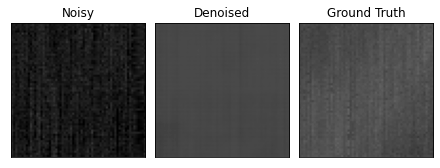

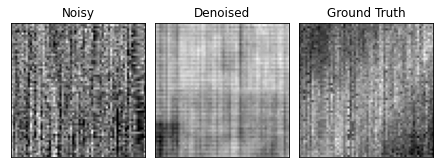

RMSE-NZ  Pred=0.0395  Noisy=0.2174 BEST
MAE-NZ   Pred=0.0329  Noisy=0.2121 BEST
PSNR     Pred=20.0 dB Noisy=5.2 dB BEST
Accuracy Pred=0.17    Noisy=0.00 BEST
SSM      Pred=0.71    Noisy=0.25
HOG MSE  Pred=0.12    Noisy=0.05
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_00_04_11_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_00_04_11_nitid_idx146.tif


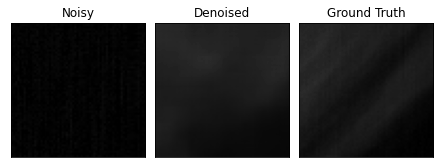

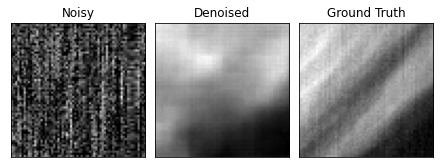

RMSE-NZ  Pred=0.0305  Noisy=0.0873 BEST
MAE-NZ   Pred=0.0255  Noisy=0.0780 BEST
PSNR     Pred=15.3 dB Noisy=6.2 dB BEST
Accuracy Pred=0.20    Noisy=0.06 BEST
SSM      Pred=0.84    Noisy=0.26
HOG MSE  Pred=0.09    Noisy=0.17
******************************************************
Index:15
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_01_00_2_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_01_00_2_nitid_idx008.tif


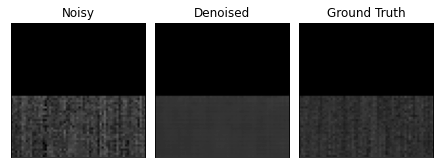

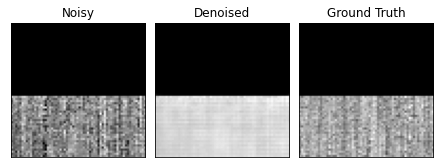

RMSE-NZ  Pred=0.0233  Noisy=0.0789 BEST
MAE-NZ   Pred=0.0125  Noisy=0.0631 BEST
PSNR     Pred=21.9 dB Noisy=11.2 dB BEST
Accuracy Pred=0.65    Noisy=0.09 BEST
SSM      Pred=0.78    Noisy=0.66
HOG MSE  Pred=0.23    Noisy=0.02
******************************************************
Index:16
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0726_03_01_15_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0726_03_01_15_nitid_idx017.tif


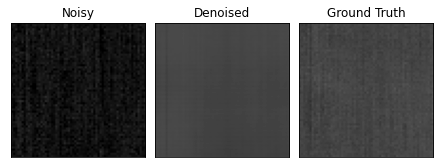

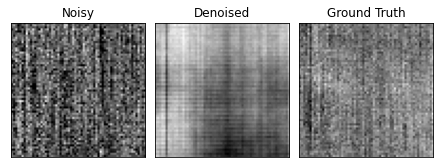

RMSE-NZ  Pred=0.0231  Noisy=0.2053 BEST
MAE-NZ   Pred=0.0186  Noisy=0.2012 BEST
PSNR     Pred=23.7 dB Noisy=4.7 dB BEST
Accuracy Pred=0.32    Noisy=0.00 BEST
SSM      Pred=0.76    Noisy=0.22
HOG MSE  Pred=0.11    Noisy=0.05
******************************************************


In [11]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
                dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
                dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )